In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(os.getcwd()+"/../../")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from ood_detection_helper import *

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 125
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.3.1'

In [3]:
with open("brain_scores.p", "rb") as f:
    score_dict = pickle.load(f)

In [4]:
score_dict.keys()

dict_keys(['train', 'test', '1year', '2year', '4year', '6year', '8year', '10year'])

In [5]:
ages = ["1year", "2year", "4year", "6year", "8-10year"]
LABELS = ["Train", "Inlier"] + ages

X_train, X_test =  score_dict["train"].copy(), score_dict["test"].copy()
outlier_scores = [score_dict[name] for name in ages[:-1]]
outlier_scores.append(np.concatenate([score_dict["8year"], score_dict["10year"]]))

In [6]:
outlier_scores[0].shape

(756, 10)

# Auxiliary model analysis

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   25.2s finished


Best: 2.920312 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
1.186154 (1.591378) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.092611 (1.593653) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.634405 (0.481522) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.758792 (0.552962) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.731366 (0.844693) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.886870 (0.506088) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.910788 (0.517666) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.865720 (0.689362) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.863275 (0.689427) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.920312 (0.538695) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


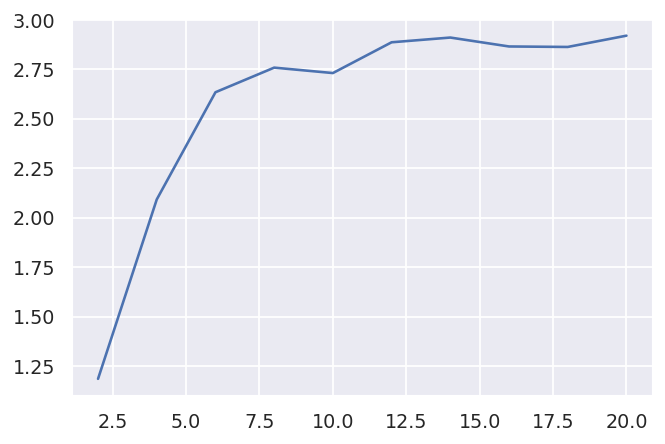

---Likelihoods---
Training: 3.289
Inlier: 1.187
1year: -19.548
2year: -17.392
4year: -11.980
6year: -9.155
8-10year: -4.944
========================= Training Flow Model =========================
Epoch 1/1000
82/82 [==============================] - 0s 5ms/step - loss: 25325.8652 - val_loss: 16868.3438
Epoch 2/1000
82/82 [==============================] - 0s 3ms/step - loss: 13832.7715 - val_loss: 11348.6367
Epoch 3/1000
82/82 [==============================] - 0s 2ms/step - loss: 9822.6992 - val_loss: 8353.8232
Epoch 4/1000
82/82 [==============================] - 0s 3ms/step - loss: 7429.0815 - val_loss: 6457.8320
Epoch 5/1000
82/82 [==============================] - 0s 3ms/step - loss: 5862.9995 - val_loss: 5186.7441
Epoch 6/1000
82/82 [==============================] - 0s 3ms/step - loss: 4790.4863 - val_loss: 4305.8374
Epoch 7/1000
82/82 [==============================] - 0s 3ms/step - loss: 4029.7498 - val_loss: 3665.3679
Epoch 8/1000
82/82 [==============================] - 0s 4

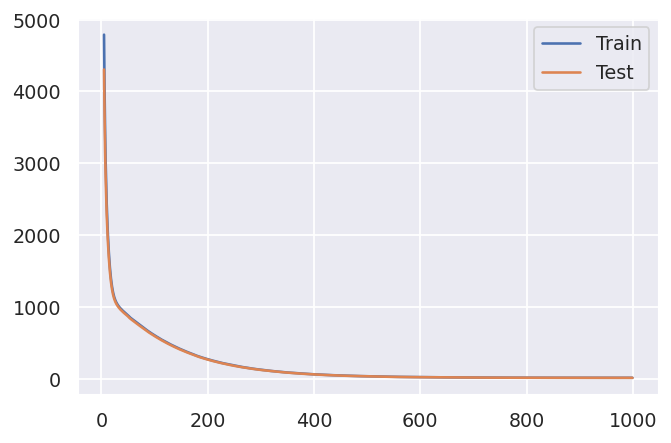

========================= Training KD Tree =========================
CPU times: user 10min 28s, sys: 6min 31s, total: 16min 59s
Wall time: 4min 51s


In [27]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

In [8]:
TEST_IDX = 0

## GMM

In [28]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1year,0.527704,1.033945,99.910188,99.856367,99.944629,0.087951,99.856469
2year,1.143360,1.754935,99.699577,99.412252,99.850847,0.263852,99.412784
4year,25.593668,10.896233,95.101533,92.286401,97.236401,3.518030,92.293099
6year,40.193492,12.645466,93.516487,90.384555,95.817227,5.364996,90.393366
8-10year,49.076517,18.834674,88.402199,80.699310,92.887615,17.941953,80.726451


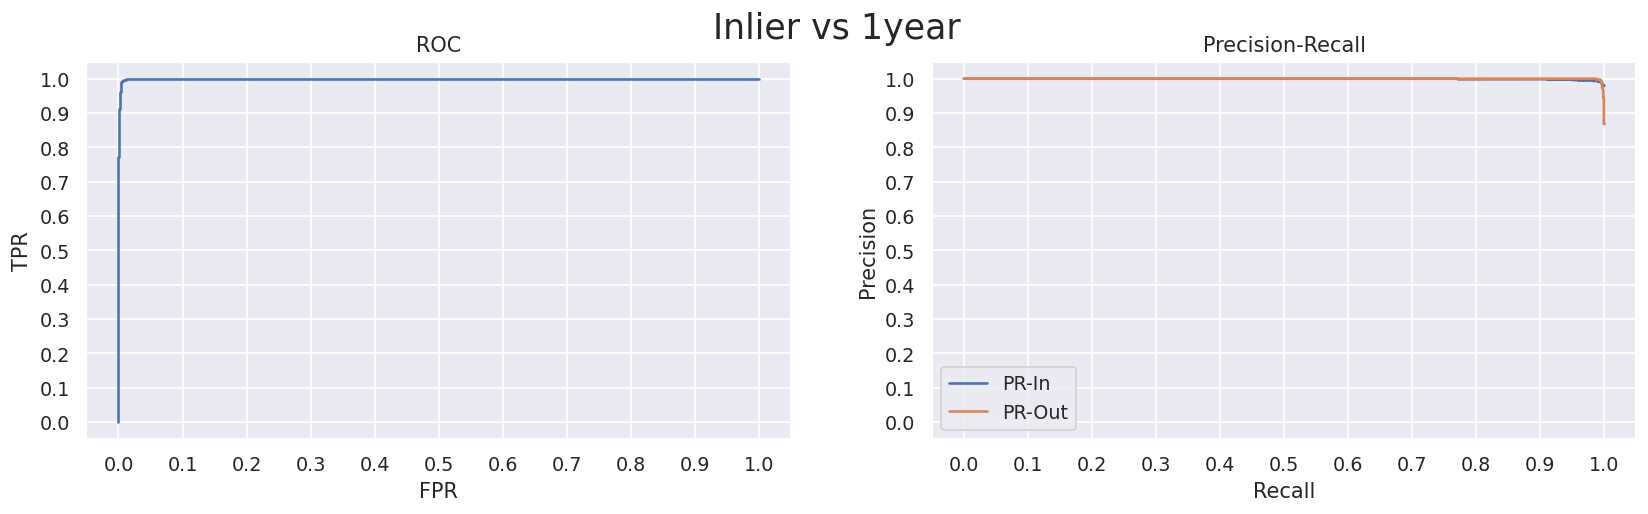

Inlier vs 1year
----------------
ROC-AUC: 99.9585
PR-AUC (In/Out): 99.9329 / 99.9746
FPR (95% TPR): 0.18%
Detection Error: 0.55%


{'fpr_tpr95': 0.001759014951627089,
 'de': 0.005502156887381155,
 'roc_auc': 0.9995846770253103,
 'pr_auc_in': 0.9993294665374499,
 'pr_auc_out': 0.9997456335886736,
 'fpr_tpr80': 0.0008795074758135445,
 'ap': 0.9993299456496817}

In [10]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

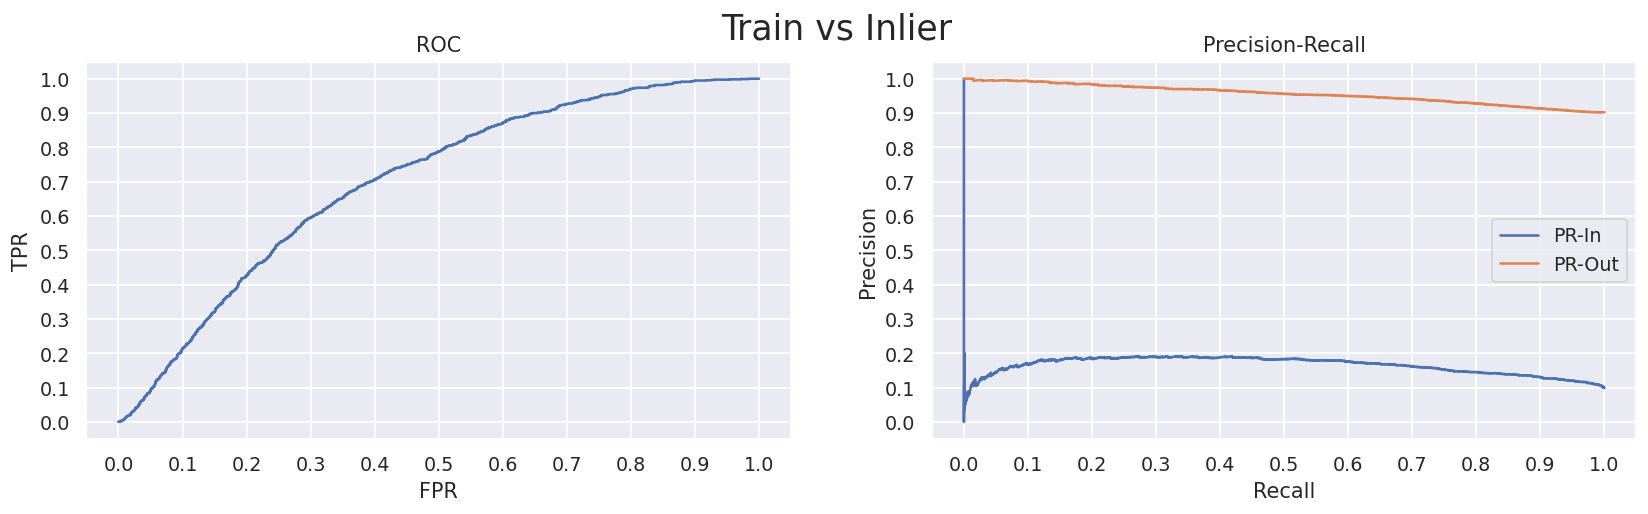

Train vs Inlier
----------------
ROC-AUC: 69.8957
PR-AUC (In/Out): 16.3893 / 95.5254
FPR (95% TPR): 75.18%
Detection Error: 34.45%


{'fpr_tpr95': 0.7518095238095238,
 'de': 0.3444570925995728,
 'roc_auc': 0.6989569878963019,
 'pr_auc_in': 0.16389338138163406,
 'pr_auc_out': 0.9552538941538712,
 'fpr_tpr80': 0.5043809523809524,
 'ap': 0.16430810753692301}

In [11]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [12]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1year,0.263852,0.307828,99.953931,99.923858,99.972352,0.087951,99.923914
2year,0.615655,1.265085,99.769092,99.544673,99.885793,0.175901,99.545090
4year,11.697449,8.332698,97.403165,94.915185,98.801236,2.462621,94.920323
6year,28.935796,12.865574,94.222253,89.568546,97.100350,9.410730,89.579082
8-10year,31.398417,15.671047,91.098489,80.955979,95.541501,12.576957,81.007246


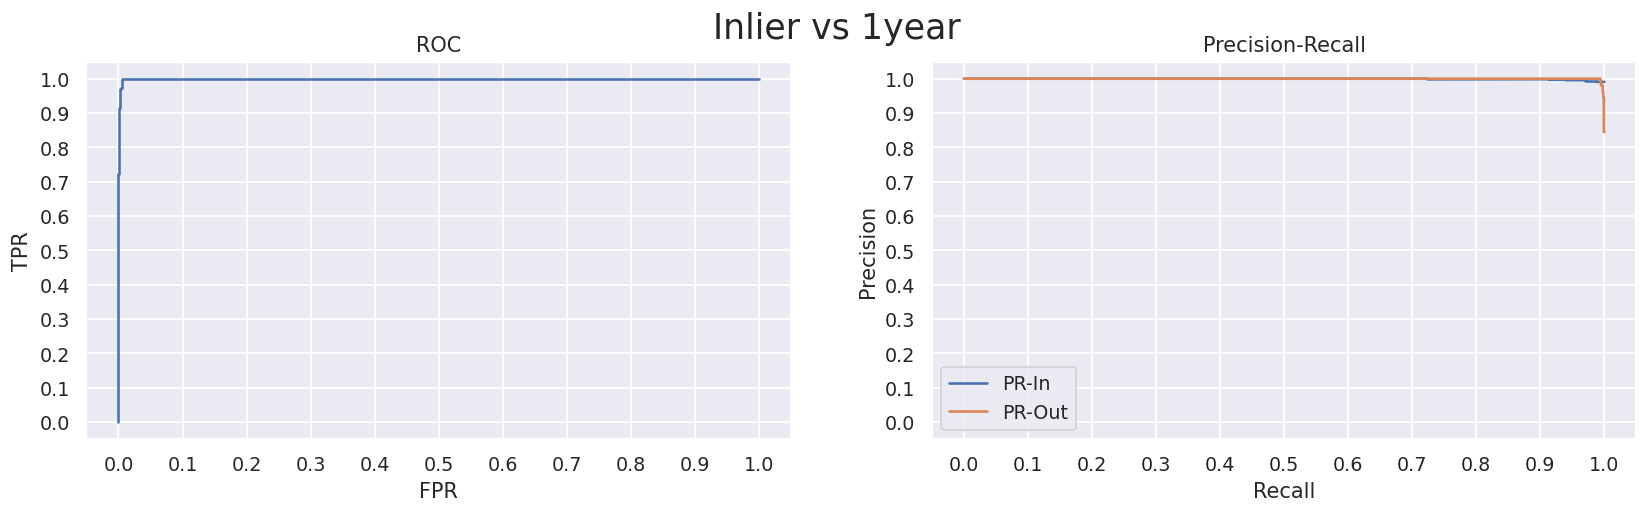

Inlier vs 1year
----------------
ROC-AUC: 99.9539
PR-AUC (In/Out): 99.9239 / 99.9724
FPR (95% TPR): 0.26%
Detection Error: 0.31%


{'fpr_tpr95': 0.002638522427440633,
 'de': 0.0030782761653474055,
 'roc_auc': 0.9995393056079073,
 'pr_auc_in': 0.9992385821918077,
 'pr_auc_out': 0.9997235223037342,
 'fpr_tpr80': 0.0008795074758135445,
 'ap': 0.9992391411129776}

In [13]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][TEST_IDX], names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

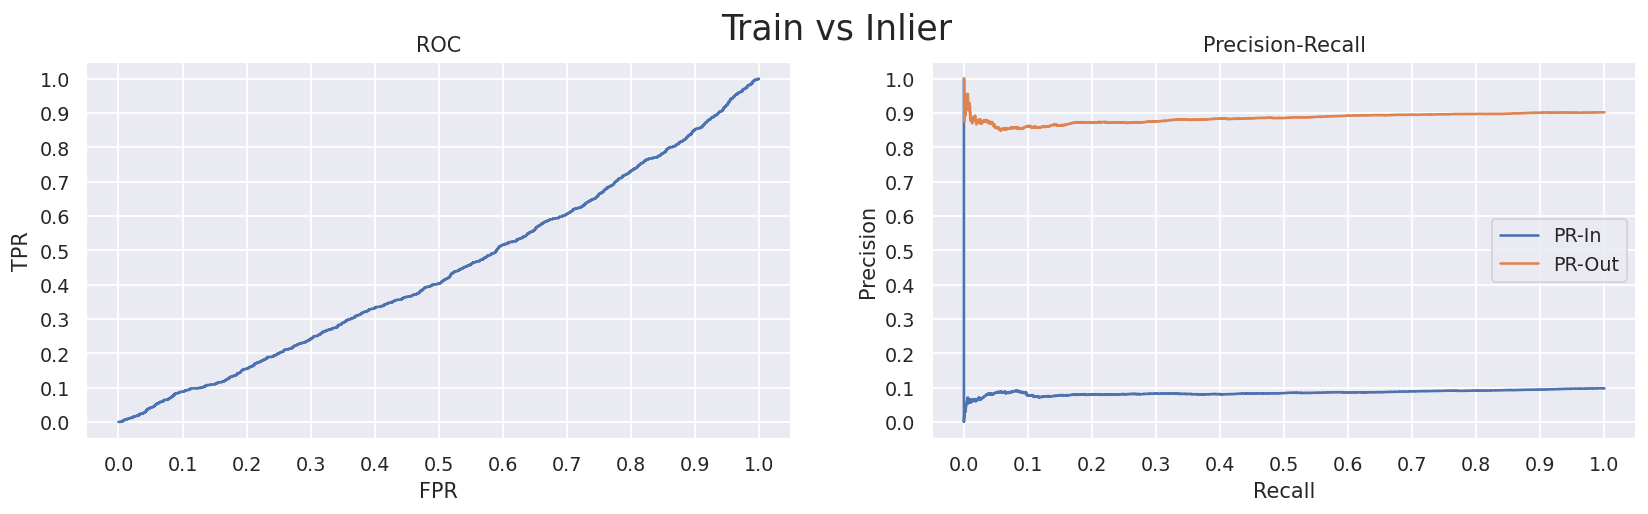

Train vs Inlier
----------------
ROC-AUC: 44.0582
PR-AUC (In/Out): 8.5004 / 88.5391
FPR (95% TPR): 96.16%
Detection Error: 49.82%


{'fpr_tpr95': 0.9616190476190476,
 'de': 0.49822402311848224,
 'roc_auc': 0.44058168949197973,
 'pr_auc_in': 0.08500355063300466,
 'pr_auc_out': 0.8853906272856988,
 'fpr_tpr80': 0.8554285714285714,
 'ap': 0.08520514102860072}

In [14]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [15]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
1year,2.198769,2.595594,99.348513,98.750357,99.644784,1.055409,98.751523
2year,3.518030,3.145826,98.852409,96.735315,99.514479,1.583113,96.740874
4year,18.645558,10.500201,95.760062,91.493482,98.001357,5.540897,91.502910
6year,39.226033,14.933805,91.504575,85.672087,95.210672,11.697449,85.686480
8-10year,40.369393,16.096070,90.246132,82.248839,94.236922,12.928760,82.274529


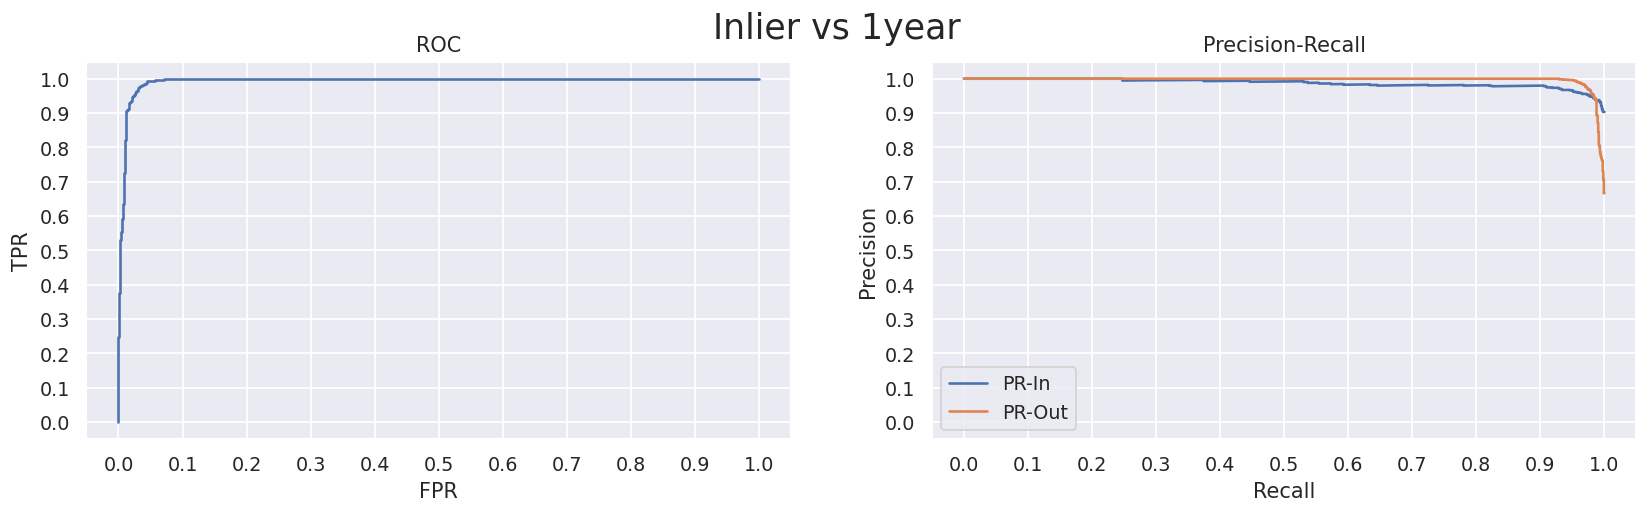

Inlier vs 1year
----------------
ROC-AUC: 99.3485
PR-AUC (In/Out): 98.7504 / 99.6448
FPR (95% TPR): 2.20%
Detection Error: 2.60%


{'fpr_tpr95': 0.02198768689533861,
 'de': 0.025955940863592566,
 'roc_auc': 0.9934851298087886,
 'pr_auc_in': 0.9875035665127188,
 'pr_auc_out': 0.9964478404620605,
 'fpr_tpr80': 0.010554089709762533,
 'ap': 0.9875152332123365}

In [16]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][TEST_IDX], names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

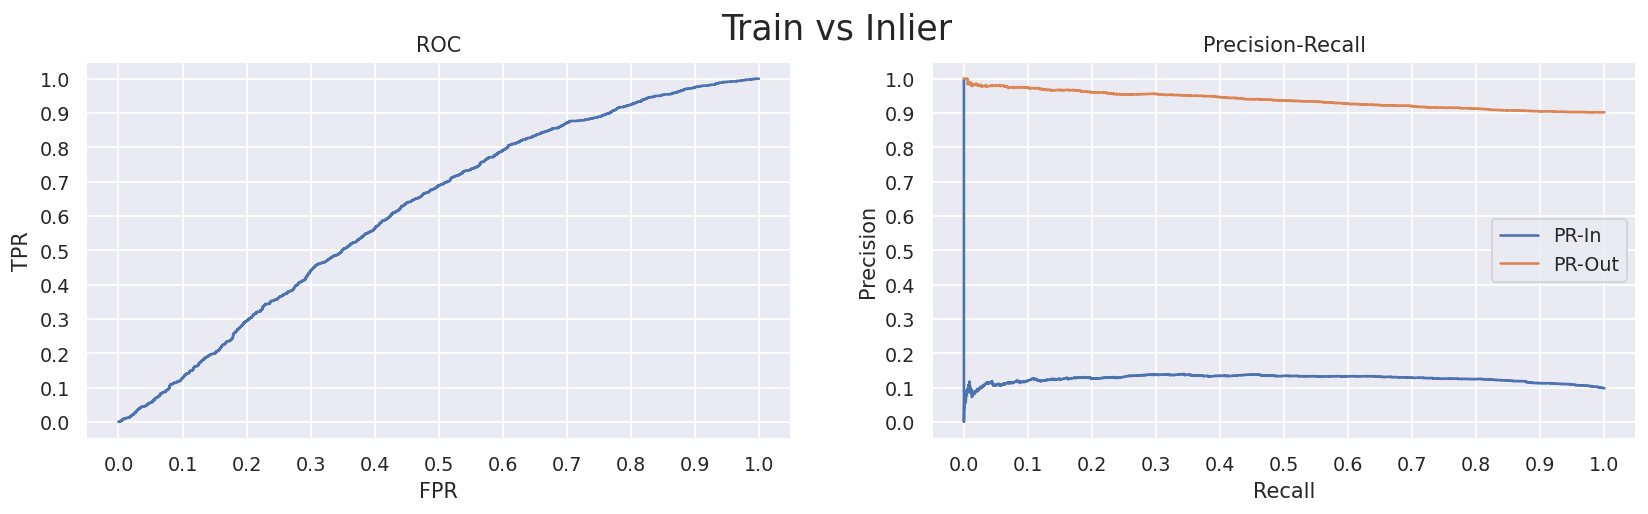

Train vs Inlier
----------------
ROC-AUC: 61.6897
PR-AUC (In/Out): 12.5346 / 93.7847
FPR (95% TPR): 83.67%
Detection Error: 40.13%


{'fpr_tpr95': 0.8366666666666667,
 'de': 0.4013172509109184,
 'roc_auc': 0.6168972651505633,
 'pr_auc_in': 0.1253457783390071,
 'pr_auc_out': 0.9378471952507732,
 'fpr_tpr80': 0.5998095238095238,
 'ap': 0.125665695605982}

In [17]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree

GMM ...
ABCD vs All
----------------
ROC-AUC: 97.4807
PR-AUC (In/Out): 98.9357 / 93.5309
FPR (95% TPR): 15.13%
Detection Error: 6.45%

Flow Model ...
ABCD vs All
----------------
ROC-AUC: 98.0180
PR-AUC (In/Out): 99.0777 / 96.1198
FPR (95% TPR): 10.91%
Detection Error: 7.85%

KD Tree ...
ABCD vs All
----------------
ROC-AUC: 96.6200
PR-AUC (In/Out): 98.2957 / 93.3850
FPR (95% TPR): 15.74%
Detection Error: 8.71%



Text(0.5, 0.98, 'Comparing Auxiliary Methods')

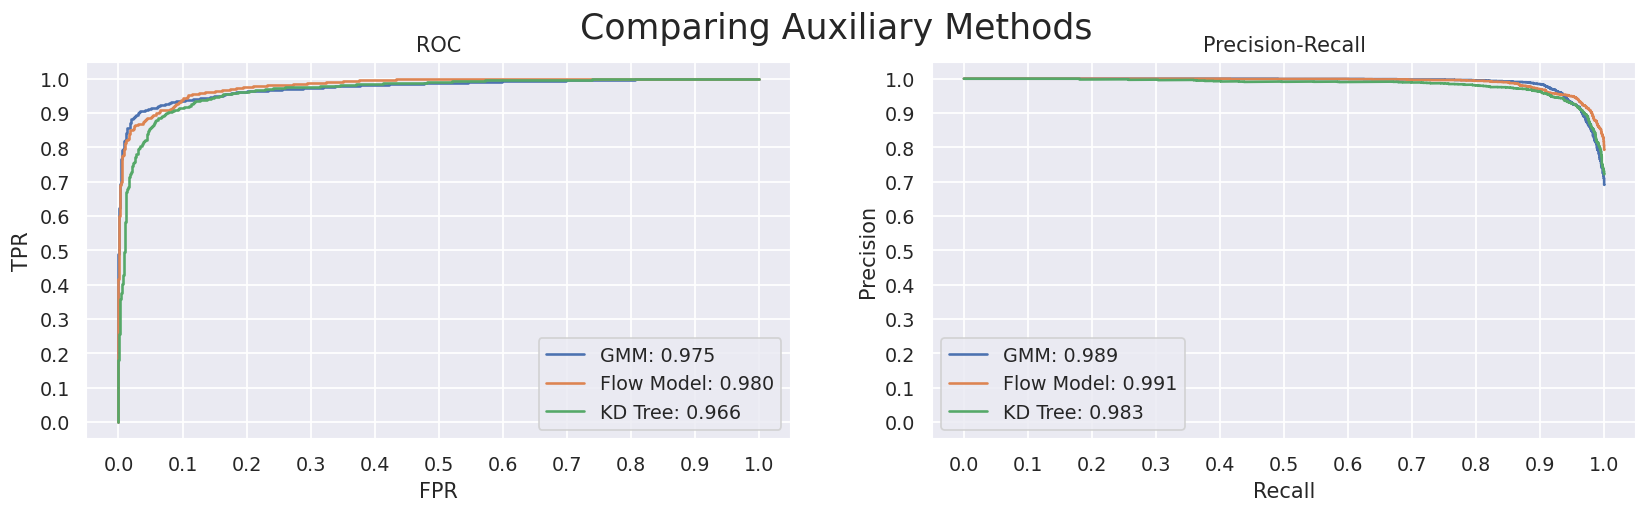

In [18]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    print(title, "...")
    ood_metrics(cifar_scores, svhn_scores, names=("ABCD", "All"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)
    print()
    
# for ax in axs:
#     ax.set(ylim=(0.8, 1.01), yticks=np.arange(0.8, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("../../Figures/aux.png", dpi=200)

## KD Tree - Further Exploration

In [19]:
from sklearn.neighbors import NearestNeighbors
N_NEIGHBOURS = 5

In [20]:
%%time
nbrs = NearestNeighbors(n_neighbors=N_NEIGHBOURS, algorithm='kd_tree').fit(X_train)

kd_train_score, indices = nbrs.kneighbors(X_train)

ood_dists = {}
kd_test_score, _ = nbrs.kneighbors(X_test)
kd_ood_scores = []
for name, ood in zip(ages, outlier_scores):
    dists, _ = nbrs.kneighbors(ood)
    kd_ood_scores.append(dists[...,-1])

CPU times: user 288 ms, sys: 2.64 ms, total: 291 ms
Wall time: 288 ms


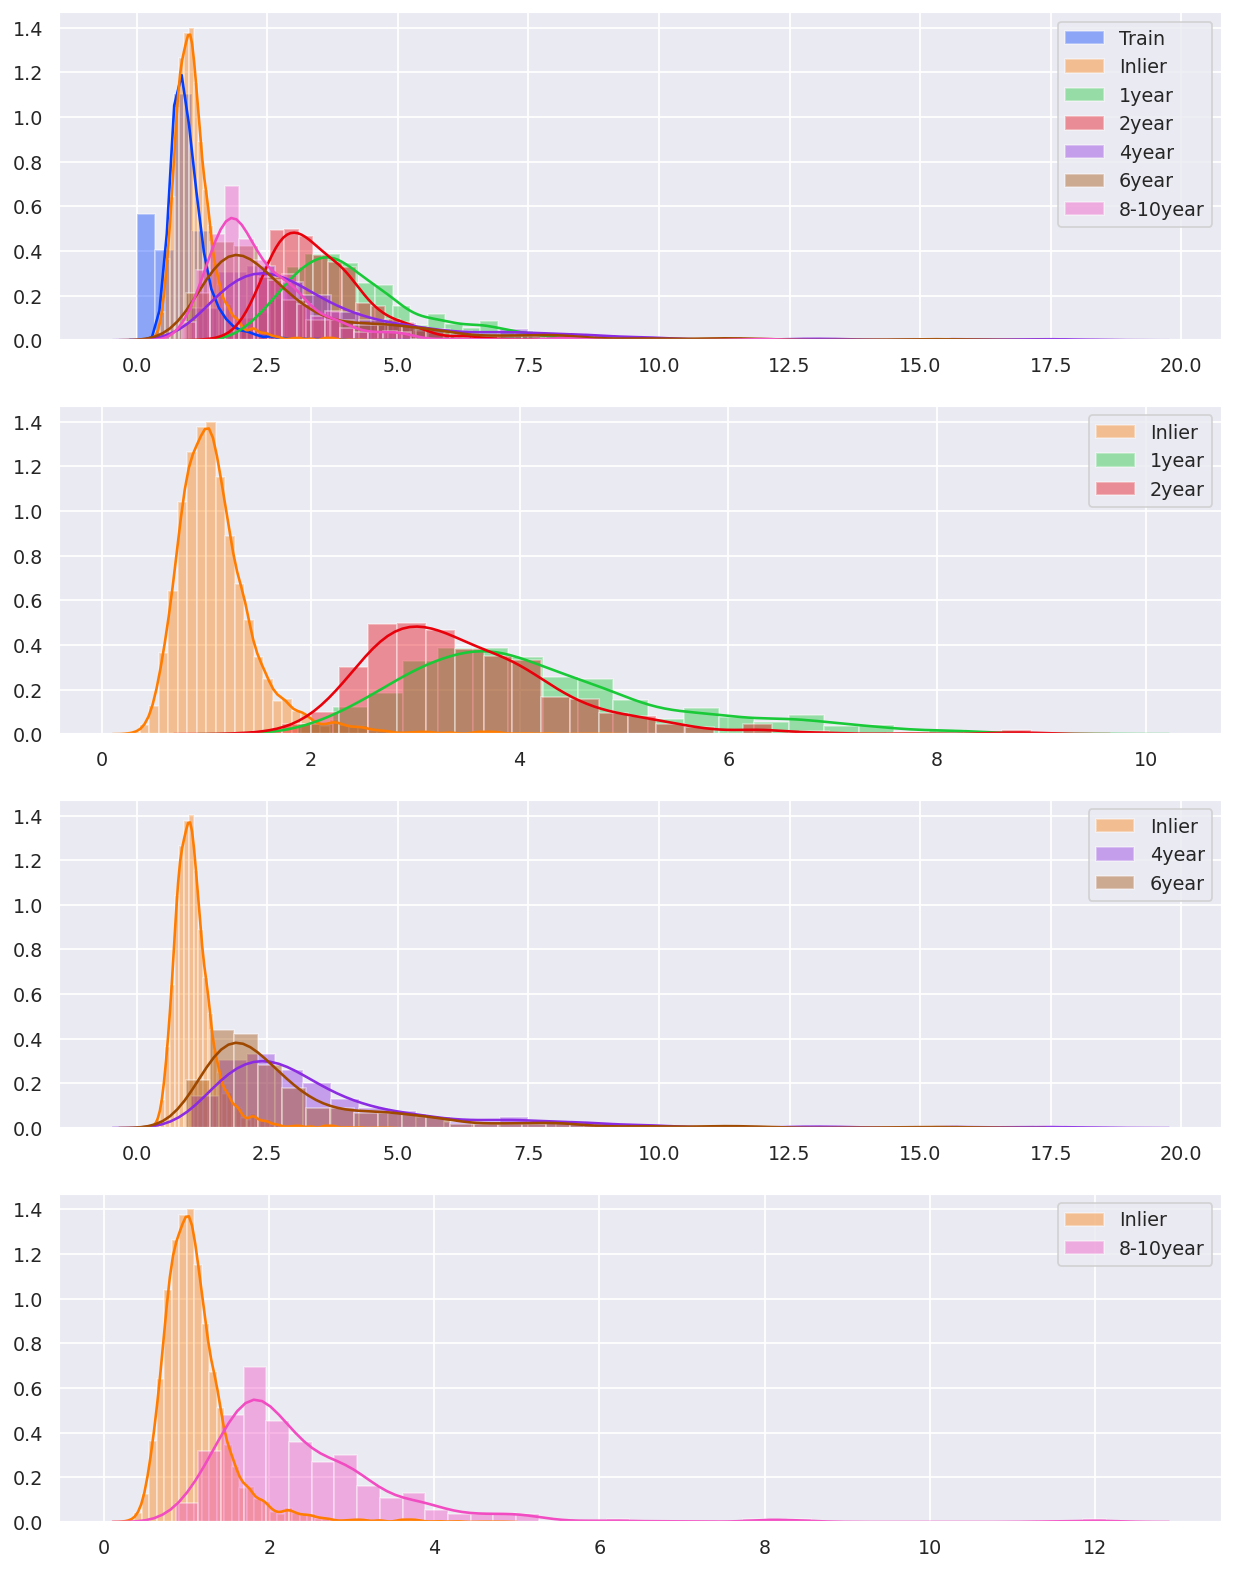

In [21]:
evaluate_model(kd_train_score, kd_test_score, kd_ood_scores, labels=LABELS)

## Curves for each age range

1year (756,)
2year (582,)
4year (519,)
6year (570,)
8-10year (609,)


Text(0.5, 0.98, 'Separation Across Ages')

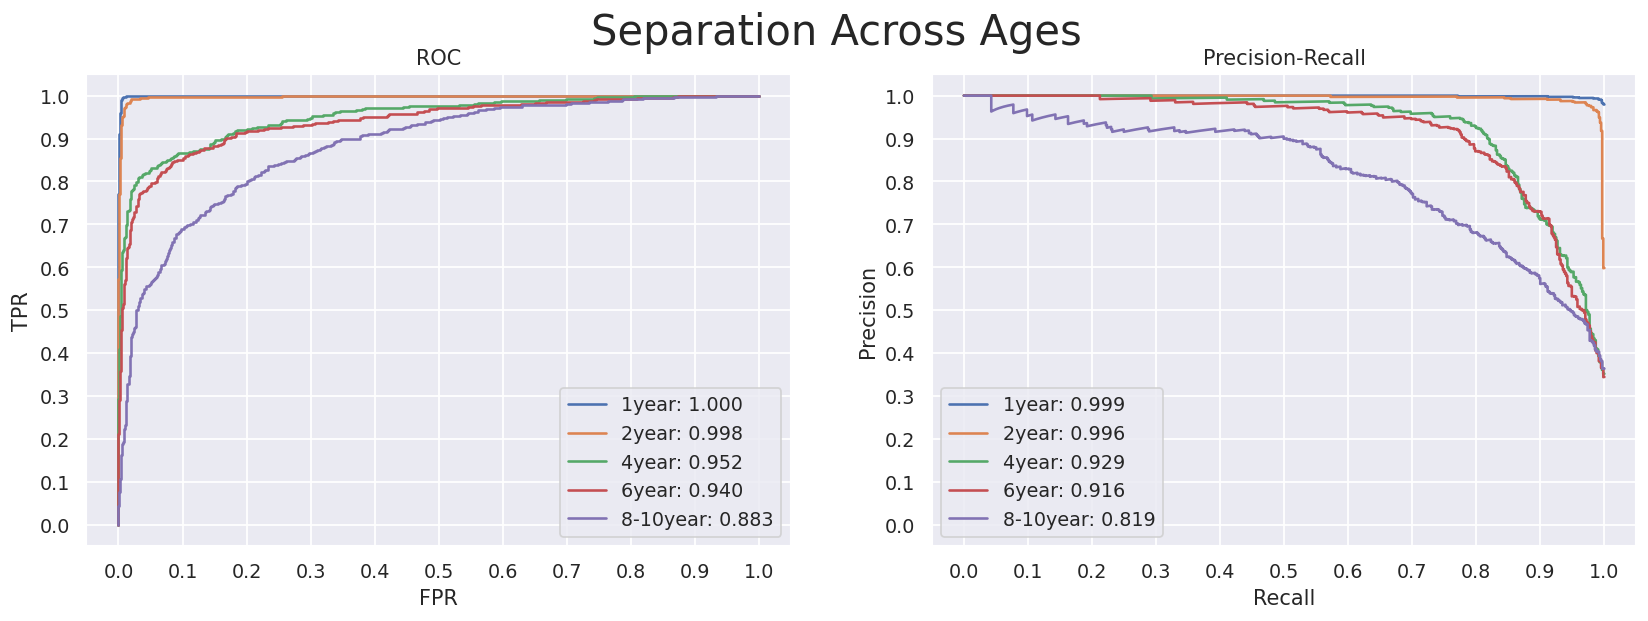

In [26]:
fig, axs = plt.subplots(1,2, figsize=(16,5))

for age, scores in zip(ages[:], results["GMM"]["ood_scores"]):
    print(age, scores.shape)
    plot_curves(-results["GMM"]["test_scores"], -scores, age, axs)
    
# for ax in axs:
#     ax.set(ylim=(-0.01, 1.01), yticks=np.arange(-0.1, 1.01, step=0.1))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Separation Across Ages",  fontsize=24)
# plt.savefig("../../Figures/brain_ages.png", dpi=200)